In [1]:
import torch
from utils import Normalise
from dataset import Simulation, FkDataset
import fk
import matplotlib.pyplot as plt
import numpy as np
import random
from utils import space_grad, space_grad_mse_loss
from unet3d import Unet3D
from resnet import ResNet
from glob import glob
import time

In [11]:
# model = ResNet.load_from_checkpoint(glob("logs/resnet/lightning_logs/version_3/checkpoints/*.ckpt")[0])
model = ResNet.load_from_checkpoint(glob("experiments_log/version_5/checkpoints/*.ckpt")[0])
model.frames_out = 50
root = "/media/ep119/DATADRIVE3/epignatelli/deepexcite/test_set/fig7.hdf5"

fkset = Simulation(root, model.frames_in, model.frames_out, model.step, transform=Normalise())

In [12]:
@torch.no_grad()
def infer(self, batch):
    x, y = batch.split((self.frames_in, self.frames_out), dim=1)

    output_sequence = torch.empty_like(y, requires_grad=False, device=torch.device("cpu"))
    loss = {}
    for i in range(self.frames_out):
        # forward pass
        y_hat = self(x).squeeze()

        # calculate loss
        current_loss = self.get_loss(y_hat, y[:, i])
        total_loss = sum(current_loss.values())
        for k, v in current_loss.items():
            loss.update({k: (loss.get(k, 0.) + v)})

        # update output sequence
        output_sequence[:, i] = y_hat

        # update input sequence with predicted frames
        if (self.frames_out > 1):
            x = torch.cat([x[:, -(self.frames_in - 1):], y_hat.unsqueeze(0).unsqueeze(0)], dim=1)
    return output_sequence.squeeze()

torch.Size([50, 3, 256, 256])
Computation time: 1.3444736003875732ms
Input


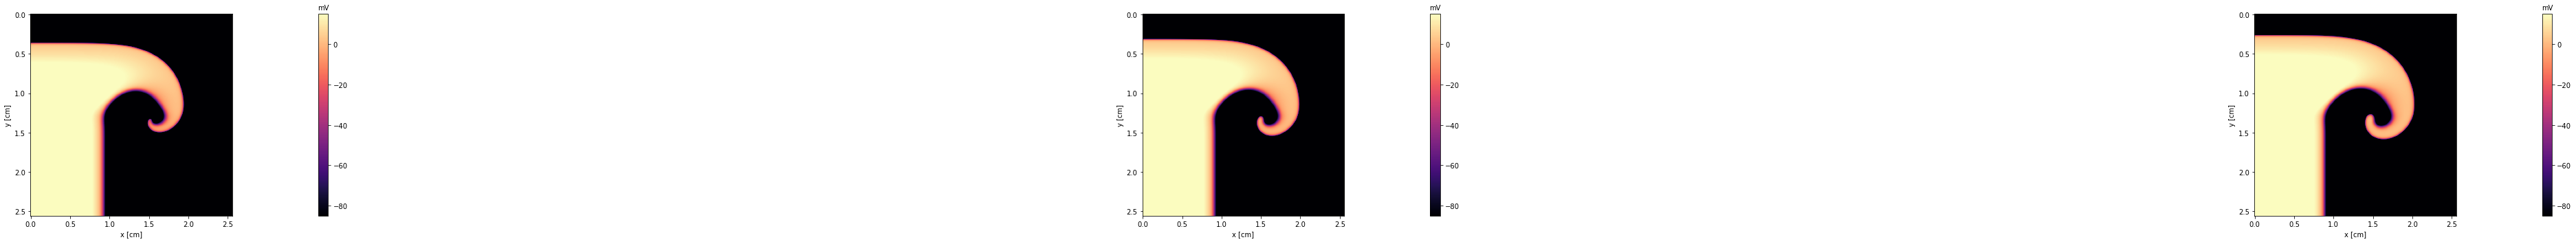

Prediction


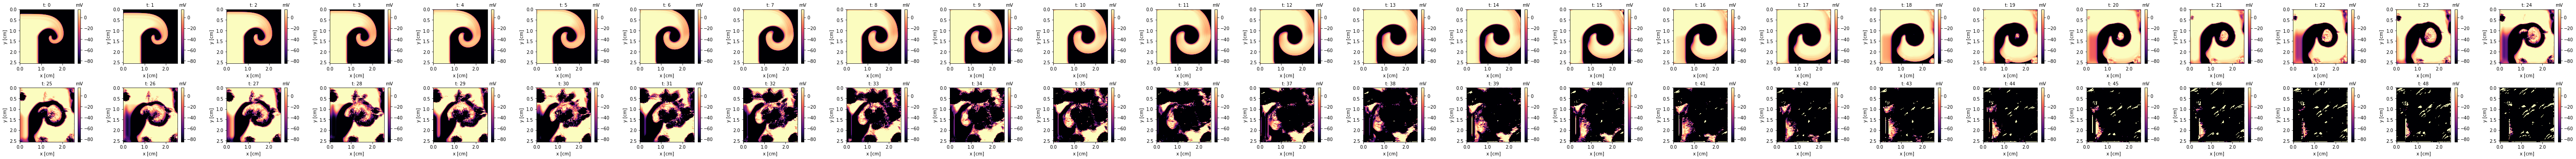

Truth


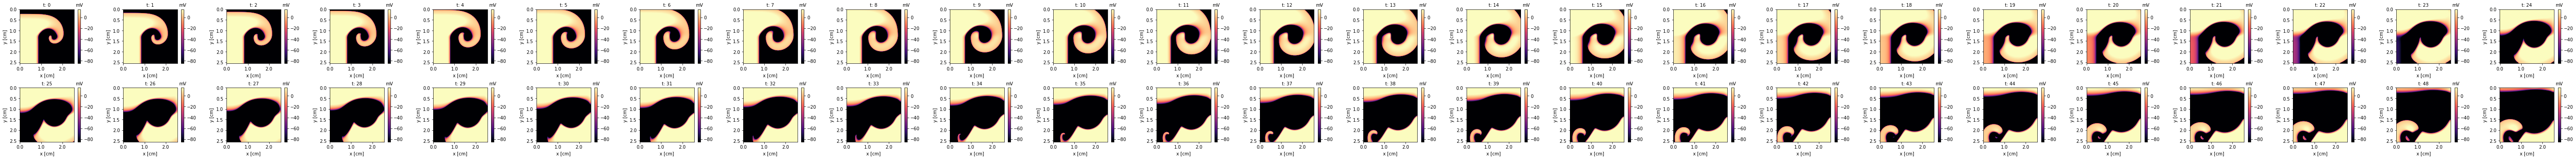

In [13]:
# get data
device = torch.device("cuda:1")
sequence = torch.as_tensor(fkset[random.randint(0, len(fkset) - 1)]).unsqueeze(0)

# to gpu
model = model.to(device)
sequence = sequence.to(device)

# format data
x = sequence[:, :model.frames_in]
y = sequence[:, model.frames_in:]

# infer
start = time.time()
pred = infer(model, sequence)
elapsed = time.time() - start
print(pred.shape)

print("Computation time: {}ms".format(elapsed))
print("Input")

# plot
x = x.squeeze()
y = y.squeeze()
rows = 25
figsize = (80, 5)
fig, ax = fk.plot.show_grid(fk.convert.u_to_V(x[:, 2].detach().cpu()), rows=rows, figsize=figsize)
plt.show()
print("Prediction")
fig, ax = fk.plot.show_grid(fk.convert.u_to_V(pred[:, 2].detach().cpu()), rows=rows, figsize=figsize, times=np.arange(len(y)))
plt.show()
print("Truth")
fig, ax = fk.plot.show_grid(fk.convert.u_to_V(y[:, 2].detach().cpu()), rows=rows, figsize=figsize, times=np.arange(len(y)))